In [41]:
#cell-1
!pip install yfinance vaderSentiment transformers torch tweepy praw newsapi-python scikit-learn shap matplotlib pandas


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [42]:
#cell -2 
# Imports and APIs
import os
import time
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# NLP & ML
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import shap

# imports - FinBERT via transformers
try:
    from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
    TRANSFORMERS_AVAILABLE = True
except Exception as e:
    TRANSFORMERS_AVAILABLE = False

# Social APIs
try:
    import tweepy
except:
    tweepy = None
try:
    import praw
except:
    praw = None
try:
    from newsapi import NewsApiClient
except:
    NewsApiClient = None

# If you leave them blank, the notebook WILL use simulated social posts
API_KEYS = {
    "twitter_bearer": "",    # e.g. 'AAAAAAAAA...'
    "reddit_client_id": "",  # e.g. 'abc123'
    "reddit_client_secret": "",
    "reddit_user_agent": "sentiment-trading-bot",
    "newsapi_key": ""
}


In [43]:
# Cell  3- Configuration: tickers and target date
# Change tickers as you wish
TICKERS = ["AAPL", "TSLA", "NVDA"]
# Prediction target date: the day we will predict for (next trading day).
# sets to next calendar day from last price we fetch.
PULL_HISTORY_DAYS = 180 # how many past days of price history to download
SENTIMENT_WINDOW_DAYS = 30  # number of prior days whose social posts we aggregate
TARGET_DATE = None  # None -> we'll set it based on latest fetched market date
print("Tickers:", TICKERS, "History days:", PULL_HISTORY_DAYS, "Sentiment window:", SENTIMENT_WINDOW_DAYS)


Tickers: ['AAPL', 'TSLA', 'NVDA'] History days: 180 Sentiment window: 30


In [44]:
# %% Cell 4 -Initialize FinBERT pipeline
FINBERT_MODEL_NAME = "yiyanghkust/finbert-tone"
finbert_pipe = None
if TRANSFORMERS_AVAILABLE:
    try:
        
        tokenizer = AutoTokenizer.from_pretrained(FINBERT_MODEL_NAME)
        model = AutoModelForSequenceClassification.from_pretrained(FINBERT_MODEL_NAME)
        finbert_pipe = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, return_all_scores=True)
        print("FinBERT loaded.")
    except Exception as e:
        print("Could not load FinBERT:", str(e))
        finbert_pipe = None
else:
    print("Transformers not available — FinBERT will be simulated.")


Device set to use mps:0


FinBERT loaded.


/opt/anaconda3/lib/python3.12/site-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [45]:
# Cell 5 - Helper functions: text cleaning, FinBERT fallback, social simulation
import re
def clean_text(text):
    t = text.replace('\n',' ').strip()
    t = re.sub(r'http\S+','', t)  # remove urls
    t = re.sub(r'[@#]','', t)      # remove @ and # 
    return t

# If FinBERT pipeline is None, we map VADER -> finbert-like score as safe fallback
def finbert_like_from_texts(texts, vader_scores=None):
    """
    texts: list of strings
    vader_scores: optional array of VADER compound scores to help map
    Returns: list of finbert-like floats in [-1,1] (positive->1, neutral->0, negative->-1)
    """
    if finbert_pipe is not None:
        out = []
        for t in texts:
            try:
                scores = finbert_pipe(t)[0]  # list of dicts with label & score
                # look for label mapping depending on model labels (e.g., positive/neutral/negative)
                # different models have different label strings; we convert to a signed score
                # computed signed = (postive - negative) if both present else use postive vs negative
                pos = next((d['score'] for d in scores if 'pos' in d['label'].lower()), 0)
                neg = next((d['score'] for d in scores if 'neg' in d['label'].lower()), 0)
                neu = next((d['score'] for d in scores if 'neu' in d['label'].lower()), 0)
                # creating a value in [-1,1]
                val = pos - neg
                out.append(float(val))
            except Exception as e:
                out.append(0.0)
        return out
    else:
        # fallback: map VADER compound -> scaled finbert-like
        if vader_scores is None:
            # if no vader, return small random noise
            return list(np.clip(np.random.normal(0, 0.05, size=len(texts)), -1, 1))
        mapped = [float(np.clip(0.6 * v + np.random.normal(0,0.05), -1, 1)) for v in vader_scores]
        return mapped

# Social post simulator for a given ticker and date
sample_phrases = [
    "Strong buy on {t} - earnings incoming!",
    "I'm worried about {t} guidance",
    "Great technical breakout for {t}",
    "Selling some shares of {t} today",
    "Holding my position in {t}",
    "Massive institutional buying seen in {t}",
    "Rumours around {t} acquisition",
    "This looks like a correction for {t}",
    "Bullish on {t} long term",
    "Short squeeze incoming for {t}"
]

def simulate_posts_for_date(ticker, date, n_posts=40):
    texts = []
    for _ in range(n_posts):
        phrase = np.random.choice(sample_phrases)
        text = phrase.format(t=ticker)
        # adding small random modifiers
        if np.random.rand() < 0.15:
            text += " 🚀"
        if np.random.rand() < 0.08:
            text = text.upper()
        texts.append({'date': pd.to_datetime(date).date(), 'text': text})
    return texts


In [46]:
#Cell 6- Social collectors (Twitter, Reddit, News)
def collect_tweets(ticker, start_date, end_date, max_results=300):
    """Attempt to collect tweets using Tweepy (Twitter API v2). Returns list of dicts with date and text."""
    if not API_KEYS.get("twitter_bearer") or tweepy is None:
        return []  # empty indicates fallback to simulation
    try:
        client = tweepy.Client(bearer_token=API_KEYS['twitter_bearer'], wait_on_rate_limit=True)
        query = f'${ticker} OR {ticker} -is:retweet lang:en'
        tweets = []
        # Tweepy Paginator for recent search
        for tweet in tweepy.Paginator(client.search_recent_tweets, query=query, start_time=start_date.isoformat()+"Z",
                                     end_time=end_date.isoformat()+"Z", max_results=100).flatten(limit=max_results):
            if hasattr(tweet, 'text'):
                tweets.append({'date': pd.to_datetime(tweet.created_at).date(), 'text': tweet.text})
        return tweets
    except Exception as e:
        print("Twitter fetch failed:", e)
        return []

def collect_reddit(ticker, start_date, end_date, max_posts=300):
    """Attempt to collect Reddit posts/comments using PRAW. Returns list of dicts."""
    if not API_KEYS.get("reddit_client_id") or praw is None:
        return []
    try:
        reddit = praw.Reddit(client_id=API_KEYS['reddit_client_id'],
                             client_secret=API_KEYS['reddit_client_secret'],
                             user_agent=API_KEYS.get('reddit_user_agent', 'sentiment-trading-bot'))
        subs = ['wallstreetbets', 'stocks', 'investing']
        posts = []
        for sub in subs:
            subreddit = reddit.subreddit(sub)
            # search for ticker in top posts in the time window
            for submission in subreddit.search(query=ticker, limit=100, sort='new'):
                created = datetime.fromtimestamp(submission.created_utc).date()
                if start_date.date() <= created <= end_date.date():
                    posts.append({'date': created, 'text': submission.title + " " + (submission.selftext or "")})
        return posts
    except Exception as e:
        print("Reddit fetch failed:", e)
        return []

def collect_news(ticker, start_date, end_date, max_articles=100):
    """Attempt to collect headlines via NewsAPI."""
    if not API_KEYS.get("newsapi_key") or NewsApiClient is None:
        return []
    try:
        client = NewsApiClient(API_KEYS['newsapi_key'])
        q = f"{ticker} OR '{ticker}' OR {ticker} stock"
        from_str = start_date.strftime('%Y-%m-%d')
        to_str = end_date.strftime('%Y-%m-%d')
        res = client.get_everything(q=q, from_param=from_str, to=to_str, language='en', page_size=100)
        articles = []
        for a in res.get('articles', [])[:max_articles]:
            published = pd.to_datetime(a['publishedAt']).date() if a.get('publishedAt') else start_date.date()
            articles.append({'date': published, 'text': (a.get('title') or '') + ". " + (a.get('description') or '')})
        return articles
    except Exception as e:
        print("News fetch failed:", e)
        return []


In [47]:
# Cell 7- Fetch price data (yfinance)
from datetime import datetime, timedelta, UTC  # UTC-aware fix

end_dt = datetime.now(UTC).date()
start_dt = end_dt - timedelta(days=PULL_HISTORY_DAYS)

price_data = {}
for t in TICKERS:
    # Explicitly set auto_adjust=False to keep 'Adj Close'
    df = yf.download(
        t,
        start=start_dt.strftime('%Y-%m-%d'),
        end=(end_dt + timedelta(days=1)).strftime('%Y-%m-%d'),
        progress=False,
        auto_adjust=False
    )
    if df.empty:
        print(f"Warning: No price data for {t}")
    else:
        df.index = pd.to_datetime(df.index)
        # handle both adjusted and non-adjusted cases
        cols = [c for c in ['Open','High','Low','Close','Adj Close','Volume'] if c in df.columns]
        price_data[t] = df[cols].copy()
        print(f"{t}: loaded {len(df)} rows ({', '.join(cols)}) from {df.index.min().date()} to {df.index.max().date()}")

common_last_dates = [df.index.max() for df in price_data.values() if not df.empty]
if common_last_dates:
    last_common = min(common_last_dates)
    TARGET_DATE = (last_common + timedelta(days=1)).date()
    print("Target date (prediction date) set to:", TARGET_DATE)
else:
    raise RuntimeError("No price data loaded; check ticker symbols or internet access.")


AAPL: loaded 124 rows (Open, High, Low, Close, Adj Close, Volume) from 2025-06-13 to 2025-12-09
TSLA: loaded 124 rows (Open, High, Low, Close, Adj Close, Volume) from 2025-06-13 to 2025-12-09
NVDA: loaded 124 rows (Open, High, Low, Close, Adj Close, Volume) from 2025-06-13 to 2025-12-09
Target date (prediction date) set to: 2025-12-10


In [48]:
#Cell 8 - Collect or simulate social posts for each ticker for the SENTIMENT_WINDOW_DAYS prior to last price date
all_posts = []  # list of dicts with keys: ticker, date, text
for t in TICKERS:
    # define date window
    last_price_date = price_data[t].index.max().date()
    start_date = pd.to_datetime(last_price_date - timedelta(days=SENTIMENT_WINDOW_DAYS - 1))
    end_date = pd.to_datetime(last_price_date)
    # Attempt to collect real data
    tweets = collect_tweets(t, start_date, end_date, max_results=500)
    reddit_posts = collect_reddit(t, start_date, end_date, max_posts=400)
    news_articles = collect_news(t, start_date, end_date, max_articles=200)
    collected = tweets + reddit_posts + news_articles
    if len(collected) == 0:
        # simulate posts per day
        for d in pd.date_range(start=start_date, end=end_date, freq='D'):
            sims = simulate_posts_for_date(t, d.date(), n_posts=np.random.randint(25,60))
            for s in sims:
                s['ticker'] = t
                all_posts.append(s)
    else:
        for p in collected:
            p['ticker'] = t
            p['text'] = p['text'] if isinstance(p['text'], str) else ''
            all_posts.append({'ticker': t, 'date': p['date'], 'text': p['text']})
print("Collected/simulated total posts:", len(all_posts))
posts_df = pd.DataFrame(all_posts)
# Clean text
if not posts_df.empty:
    posts_df['date'] = pd.to_datetime(posts_df['date'])
    posts_df['clean_text'] = posts_df['text'].apply(clean_text)


Collected/simulated total posts: 3791


In [49]:
# Cell 9- posts per ticker/day
if posts_df.empty:
    print("No posts available.")
else:
    summary = posts_df.groupby(['ticker', posts_df['date'].dt.date]).size().rename('count').reset_index()
    print(summary.head(10).to_string(index=False))
    print("\n(Counts above show how many social items per ticker per day are available/simulated.)")


ticker       date  count
  AAPL 2025-11-10     55
  AAPL 2025-11-11     51
  AAPL 2025-11-12     44
  AAPL 2025-11-13     57
  AAPL 2025-11-14     40
  AAPL 2025-11-15     41
  AAPL 2025-11-16     44
  AAPL 2025-11-17     49
  AAPL 2025-11-18     41
  AAPL 2025-11-19     34

(Counts above show how many social items per ticker per day are available/simulated.)


In [50]:
# %% Cell 10 - VADER sentiment scoring (post level) and aggregate per day
analyzer = SentimentIntensityAnalyzer()
posts_df['vader_compound'] = posts_df['clean_text'].apply(lambda t: analyzer.polarity_scores(t)['compound'])
# Get finbert-like per post (attempt true FinBERT if any available)
try:
    posts_df['finbert_like'] = finbert_like_from_texts(posts_df['clean_text'].tolist(), posts_df['vader_compound'].tolist())
except Exception as e:
    posts_df['finbert_like'] = finbert_like_from_texts(posts_df['clean_text'].tolist(), posts_df['vader_compound'].tolist())

# Calculating Aggregate to daily by ticker
daily_sent = posts_df.groupby(['ticker', posts_df['date'].dt.date]).agg(
    n_posts = ('clean_text','count'),
    vader_mean = ('vader_compound','mean'),
    vader_median = ('vader_compound','median'), 
    finbert_mean = ('finbert_like','mean'),
    finbert_median = ('finbert_like','median')
).reset_index().rename(columns={'date':'day'})
print(daily_sent.head(8).to_string(index=False))


ticker        day  n_posts  vader_mean  vader_median  finbert_mean  finbert_median
  AAPL 2025-11-10       55    0.153964           0.0     -0.007491       -0.007614
  AAPL 2025-11-11       51    0.191086           0.0      0.048505       -0.007614
  AAPL 2025-11-12       44    0.205525           0.0      0.094738       -0.007399
  AAPL 2025-11-13       57    0.213409           0.0      0.114410       -0.007614
  AAPL 2025-11-14       40    0.113723           0.0     -0.135892       -0.141273
  AAPL 2025-11-15       41    0.132146           0.0     -0.122934       -0.020194
  AAPL 2025-11-16       44    0.186759           0.0     -0.056694       -0.020194
  AAPL 2025-11-17       49    0.193904           0.0      0.040708       -0.007614


In [51]:
# Cell 11 (merging)
print("Using internal RSI calculation and automatic MultiIndex flattening if needed.")

features = {}

for t in TICKERS:
    if t not in price_data:
        print(f"No price data for {t}, skipping.")
        continue

    # Copy and flatten MultiIndex columns if present
    price_df = price_data[t].copy()
    if isinstance(price_df.columns, pd.MultiIndex):
        price_df.columns = [col[0] if isinstance(col, tuple) else col for col in price_df.columns]

    price_df['day_date'] = price_df.index.date

    # Merge daily sentiment
    sent_t = daily_sent[daily_sent['ticker'] == t].copy()
    sent_t.rename(columns={'day': 'day_date'}, inplace=True)
    sent_t['day_date'] = pd.to_datetime(sent_t['day_date']).dt.date

    merged = pd.merge(price_df, sent_t, on='day_date', how='left')

    # Technical indicators
    merged['ma5'] = merged['Close'].rolling(window=5, min_periods=1).mean()
    merged['ma10'] = merged['Close'].rolling(window=10, min_periods=1).mean()
    merged['ret1'] = merged['Close'].pct_change(1)
    merged['ret5'] = merged['Close'].pct_change(5)

    # Internal RSI (no external dependency)
    delta = merged['Close'].diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.rolling(14, min_periods=1).mean()
    roll_down = down.rolling(14, min_periods=1).mean()
    rs = roll_up / (roll_down + 1e-9)
    merged['rsi14'] = 100 - (100 / (1 + rs))

    features[t] = merged
    print(f"{t}: merged {merged.shape[0]} rows, sentiment days merged: {merged['vader_mean'].notna().sum()}")


Using internal RSI calculation and automatic MultiIndex flattening if needed.
AAPL: merged 124 rows, sentiment days merged: 21
TSLA: merged 124 rows, sentiment days merged: 21
NVDA: merged 124 rows, sentiment days merged: 21


#### Integrates Sentiment Scores: It combines the VADER and FinBERT daily mean scores into one final predictor.
Generates Trading Signals: It creates the Rule-Based Trading Signal (Buy, Sell, or Hold), which is the primary output of the system before the ML fallback is considered.

In [52]:
# %% Cell 12 - Combined sentiment score and rule-based Buy/Sell/Hold signal
for t, df in features.items():
    df = df.copy()
    # Fill missing sentiment with 0 (neutral) so rows are usable
    df['vader_mean'] = df['vader_mean'].fillna(0.0)
    df['finbert_mean'] = df['finbert_mean'].fillna(0.0)
    df['combined_sentiment'] = 0.5 * df['finbert_mean'] + 0.5 * df['vader_mean']
    # Next day label for up/down (1 if next close > today close)
    df['next_close'] = df['Close'].shift(-1)
    df['up_label'] = (df['next_close'] > df['Close']).astype(int)
    # Rule for Buy/Sell/Hold:
    # BUY if combined_sentiment > 0.08 and Close > ma5
    # SELL if combined_sentiment < -0.08 and Close < ma5
    # else HOLD
    def rule_sig(row):
        if row['combined_sentiment'] > 0.08 and row['Close'] > row['ma5']:
            return 'BUY'
        elif row['combined_sentiment'] < -0.08 and row['Close'] < row['ma5']:
            return 'SELL'
        else:
            return 'HOLD'
    df['rule_signal'] = df.apply(rule_sig, axis=1)
    features[t] = df
    print(f"{t}: signals generated, last combined_sentiment = {df['combined_sentiment'].iloc[-1]:.4f}, last rule = {df['rule_signal'].iloc[-1]}")


AAPL: signals generated, last combined_sentiment = 0.0047, last rule = HOLD
TSLA: signals generated, last combined_sentiment = -0.0010, last rule = HOLD
NVDA: signals generated, last combined_sentiment = -0.0259, last rule = HOLD


#### Model Training and Preparation

In [53]:
#cell 13
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd

FEATURE_COLS = ['combined_sentiment', 'ret1', 'ret5', 'ma5', 'rsi14']
models = {} 

print("Step 1: Running Logistic Regression Model Training and Prediction")

for t, df in features.items():
    
    # 1. Prepare Data
    required_cols = FEATURE_COLS + ['up_label']
    df_model = df.dropna(subset=required_cols).copy()
    
    if df_model.empty:
        print(f"Skipping {t}: Not enough data after dropping NaNs.")
        continue
        
    X = df_model[FEATURE_COLS]
    y = df_model['up_label']
    
    # Split data (using 80% for training)
    split_index = int(len(X) * 0.8)
    X_train = X.iloc[:split_index]
    # NEW: Define X_test and y_test correctly
    X_test = X.iloc[split_index:] 
    y_train = y.iloc[:split_index]
    y_test = y.iloc[split_index:] # <--- This line defines y_test!
    
    # 2. Train Model
    model = LogisticRegression(solver='liblinear', random_state=42,)
    model.fit(X_train, y_train)
    
    # NEW: Store the trained model AND X_test/y_test data
    models[t] = {
        'model': model, 
        'features': FEATURE_COLS,
        'X_test': X_test, # <-- Saving it for SHAP and Classification Metrics
        'y_test': y_test  # <-- Saving it for Classification Metrics
    }
    
    # 3. Generate Prediction for All Data
    y_pred_proba = model.predict_proba(X)[:, 1]
    df.loc[df_model.index, 'fallback_pred_up'] = y_pred_proba
    features[t] = df
    
    print(f" Model trained and 'fallback_pred_up' created for {t}.")

Step 1: Running Logistic Regression Model Training and Prediction
 Model trained and 'fallback_pred_up' created for AAPL.
 Model trained and 'fallback_pred_up' created for TSLA.
 Model trained and 'fallback_pred_up' created for NVDA.


#### Strategy-Level Evaluation and Backtesting

In [54]:
# cell 14
INITIAL_CAPITAL = 10000.0
# Assuming 252 trading days per year for annualizing metrics
TRADING_DAYS_PER_YEAR = 252
DECISION_POINTS = {
    'Conservative (LR >= 65%)': 0.65, # Buy if LR confidence is 65% or higher
    'Moderate (LR >= 60%)': 0.60,     # Buy if LR confidence is 60% or higher
    'Aggressive (LR >= 55%)': 0.55    # Buy if LR confidence is 55% or higher
}

print(f" Running Looped Strategy Backtesting with ${INITIAL_CAPITAL:,.2f} Capital ---")

results_summary = []

for t, df in features.items():
    
    if 'fallback_pred_up' not in df.columns:
        print(f"Skipping {t}: 'fallback_pred_up' column is missing.")
        continue

    print(f"\n>>>> Ticker: {t} <<<<")
    
    # Calculate Buy-and-Hold Benchmark return once per ticker
    df_benchmark = df.dropna(subset=['ret1'])
    if df_benchmark.empty:
        bh_return = 0.0
    else:
        # Compounded Buy-and-Hold return
        bh_return = ((1 + df_benchmark['ret1']).prod() - 1) * 100 
    
    # Run a backtest for each decision point
    for label, buy_threshold in DECISION_POINTS.items():
        
        # 1. Signal Generation: Create a unique signal column for this strategy run
        signal_col_name = f'signal_{int(buy_threshold*100)}'
        df[signal_col_name] = np.where(df['fallback_pred_up'] >= buy_threshold, 'Buy', 'Hold')
        
        # 2. Strategy Return Calculation
        df['strategy_ret'] = np.where(df[signal_col_name] == 'Buy', df['ret1'], 0)
        
        # Drop rows where returns/signals might be NaN
        df_clean = df.dropna(subset=['strategy_ret', 'ret1']).copy()
        
        if df_clean.empty:
            print(f"  - {label}: No clean data for calculation.")
            continue
            
        # 3. Capital and Revenue Tracking
        df_clean['cum_multiplier'] = (1 + df_clean['strategy_ret']).cumprod()
        df_clean['equity_curve'] = INITIAL_CAPITAL * df_clean['cum_multiplier']
        
        # 4. Strategy-Level Evaluation (Risk Metrics)
        
        # Annualized Volatility (Risk)
        annualized_volatility = df_clean['strategy_ret'].std() * np.sqrt(TRADING_DAYS_PER_YEAR) * 100
        
        # Sharpe Ratio (Return/Risk, assuming Risk-Free Rate = 0)
        # Using the standard calculation: Mean Daily Return / Std Dev of Daily Returns * sqrt(252)
        sharpe_ratio = (df_clean['strategy_ret'].mean() / df_clean['strategy_ret'].std()) * np.sqrt(TRADING_DAYS_PER_YEAR)
        
        # Maximum Drawdown (Worst-case loss)
        peak = df_clean['equity_curve'].cummax()
        drawdown = (df_clean['equity_curve'] / peak) - 1
        max_drawdown = drawdown.min() * 100
        
        # Final Return Metrics
        final_capital = df_clean['equity_curve'].iloc[-1]
        net_revenue = final_capital - INITIAL_CAPITAL
        total_percentage_return = (final_capital / INITIAL_CAPITAL - 1) * 100
        
        # Store results
        results_summary.append({
            'Ticker': t,
            'Strategy': label,
            'Total Return (%)': total_percentage_return,
            'BH Return (%)': bh_return,
            'Sharpe Ratio': sharpe_ratio,
            'Max Drawdown (%)': max_drawdown,
            'Annual Volatility (%)': annualized_volatility,
            'Final Capital ($)': final_capital,
            'Net Revenue ($)': net_revenue,
        })
        
        print(f"  - {label}: Final Capital: ${final_capital:,.2f} | Total Return: {total_percentage_return:,.2f}% | Sharpe Ratio: {sharpe_ratio:,.2f}")


# Final Summary
print("\n" + "=" * 100)
print("FINAL BACKTESTING SUMMARY (Includes Risk Metrics)")
print("=" * 100)

summary_df = pd.DataFrame(results_summary)
# Reorder of the columns for readability, putting Ticker/Strategy first
summary_df = summary_df[['Ticker', 'Strategy', 'Total Return (%)', 'BH Return (%)', 'Sharpe Ratio', 'Max Drawdown (%)', 'Annual Volatility (%)', 'Final Capital ($)', 'Net Revenue ($)']]

print(summary_df.to_markdown(index=False, floatfmt=",.2f"))

 Running Looped Strategy Backtesting with $10,000.00 Capital ---

>>>> Ticker: AAPL <<<<
  - Conservative (LR >= 65%): Final Capital: $9,651.68 | Total Return: -3.48% | Sharpe Ratio: -0.84
  - Moderate (LR >= 60%): Final Capital: $9,726.87 | Total Return: -2.73% | Sharpe Ratio: -0.34
  - Aggressive (LR >= 55%): Final Capital: $11,705.04 | Total Return: 17.05% | Sharpe Ratio: 1.72

>>>> Ticker: TSLA <<<<
  - Conservative (LR >= 65%): Final Capital: $10,000.00 | Total Return: 0.00% | Sharpe Ratio: nan
  - Moderate (LR >= 60%): Final Capital: $6,828.75 | Total Return: -31.71% | Sharpe Ratio: -4.42
  - Aggressive (LR >= 55%): Final Capital: $7,921.26 | Total Return: -20.79% | Sharpe Ratio: -1.25

>>>> Ticker: NVDA <<<<
  - Conservative (LR >= 65%): Final Capital: $10,958.59 | Total Return: 9.59% | Sharpe Ratio: 2.50
  - Moderate (LR >= 60%): Final Capital: $12,193.04 | Total Return: 21.93% | Sharpe Ratio: 3.44
  - Aggressive (LR >= 55%): Final Capital: $14,391.54 | Total Return: 43.92% | S

/var/folders/nk/g3yk2lnj18123kwq20vk0_bc0000gn/T/ipykernel_42948/959683788.py:59: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = (df_clean['strategy_ret'].mean() / df_clean['strategy_ret'].std()) * np.sqrt(TRADING_DAYS_PER_YEAR)


#### Model-Level Assessment (Classification Metrics)

In [55]:
#cell 15
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
classification_results = []

for t in models.keys():
    
    model_data = models[t]
    clf = model_data['model']
    X_test = model_data.get('X_test')
    y_test = model_data.get('y_test')

    if X_test is None or y_test is None or X_test.empty:
        print(f"Skipping {t}: Test data (X_test or y_test) not available or empty.")
        continue

    # Predict on the test set
    y_pred = clf.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0) # zero_division=0 prevents warnings/errors for no positive predictions
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    # Calculate Confusion Matrix values (True Negative, False Positive, False Negative, True Positive)
    # CM structure: [[TN, FP], [FN, TP]]
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel() if len(cm.ravel()) == 4 else (0, 0, 0, 0)
    
    # Calculates Buy/Sell signal metrics
    num_test_samples = len(y_test)
    num_buys = (y_pred == 1).sum() # Number of predicted 'Buy' signals (class 1)
    
    classification_results.append({
        'Ticker': t,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Total Test Samples': num_test_samples,
        'Predicted Buys (TP + FP)': num_buys,
        'True Positives (TP)': tp,
        'False Positives (FP)': fp,
    })

# Final Summary Table for Model Evaluation
print("\n" + "=" * 80)
print("MODEL CLASSIFICATION METRICS (Tested on unseen data)")
print("=" * 80)

model_df = pd.DataFrame(classification_results)
print(model_df.to_markdown(index=False, floatfmt=",.4f"))


MODEL CLASSIFICATION METRICS (Tested on unseen data)
| Ticker   |   Accuracy |   Precision |   Recall |   F1-Score |   Total Test Samples |   Predicted Buys (TP + FP) |   True Positives (TP) |   False Positives (FP) |
|:---------|-----------:|------------:|---------:|-----------:|---------------------:|---------------------------:|----------------------:|-----------------------:|
| AAPL     |     0.4167 |      0.4167 |   1.0000 |     0.5882 |                   24 |                         24 |                    10 |                     14 |
| TSLA     |     0.5000 |      0.5000 |   1.0000 |     0.6667 |                   24 |                         24 |                    12 |                     12 |
| NVDA     |     0.4583 |      0.3750 |   0.2727 |     0.3158 |                   24 |                          8 |                     3 |                      5 |


In [ ]:
#Cell 16: Generate Final Prediction DataFrame
import pandas as pd
from datetime import datetime

# Using the Aggressive 55% threshold for the final signal decision, as it was the mode leading to the best NVDA results.
FINAL_THRESHOLD = 0.55 
final_predictions = []
# Ensuring TARGET_DATE is treated as a date object
TARGET_DATE = pd.to_datetime(TARGET_DATE) 

for t, df in features.items():
    # Getting the last row of the feature DataFrame (latest available data)
    latest_data = df.iloc[-1]
    
    #Getting Fallback Model Prediction (Probability)
    X_latest_pred = latest_data[FEATURE_COLS].to_frame().T.fillna(0)
    
    # Ensuring the model exists, reindex features, and predicting probability
    if t in models and models[t]['model'] is not None:
        model = models[t]['model']
        X_latest_pred = X_latest_pred.reindex(columns=models[t]['features'], fill_value=0)
        
        # Getting probability of 'Up' (class 1)
        prob_up = model.predict_proba(X_latest_pred)[:, 1][0]
    else:
        prob_up = 0.5
    
    #Determining Final Signal based on primary rule OR fallback confidence
    
    rule_signal = latest_data['rule_signal']
    final_signal = 'HOLD' # Default
    
    # Using explicit date column from the Series to avoid index type error
    based_on_date = latest_data['day_date']
    
    if rule_signal in ['BUY', 'SELL']:
        # Primary system: Use the rule-based signal
        final_signal = rule_signal
    elif prob_up >= FINAL_THRESHOLD:
        # Fallback system: Use LR if confident enough (>=55%)
        final_signal = 'BUY' 
    
    final_predictions.append({
        'predict_date': TARGET_DATE.date(),
        'based_on_date': based_on_date, # Now uses the safe, explicit date column value
        'ticker': t,
        'combined_sentiment': latest_data['combined_sentiment'],
        'rule_signal': rule_signal,
        'fallback_prob_up': prob_up,
        'final_signal': final_signal,
    })

# Define res_df
res_df = pd.DataFrame(final_predictions)

#Clean up res_df for user display
res_df = res_df[['predict_date', 'based_on_date', 'ticker', 'combined_sentiment', 'rule_signal', 'fallback_prob_up', 'final_signal']]

/var/folders/nk/g3yk2lnj18123kwq20vk0_bc0000gn/T/ipykernel_42948/3960308377.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_latest_pred = latest_data[FEATURE_COLS].to_frame().T.fillna(0)
/var/folders/nk/g3yk2lnj18123kwq20vk0_bc0000gn/T/ipykernel_42948/3960308377.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_latest_pred = latest_data[FEATURE_COLS].to_frame().T.fillna(0)
/var/folders/nk/g3yk2lnj18123kwq20vk0_bc0000gn/T/ipykernel_42948/3960308377.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated a

##### Final Output and Persistence

In [ ]:
#Cell 17 - Save prediction CSV and show a user-friendly view
res_df.to_csv('live_sentiment_predictions.csv', index=False)
print("Saved predictions to live_sentiment_predictions.csv")
# Nicely print final results
from IPython.display import display, HTML
display(HTML(res_df.to_html(index=False)))


Saved predictions to live_sentiment_predictions.csv


predict_date,based_on_date,ticker,combined_sentiment,rule_signal,fallback_prob_up,final_signal
2025-12-10,2025-12-09,AAPL,0.004741,HOLD,0.631368,BUY
2025-12-10,2025-12-09,TSLA,-0.000953,HOLD,0.550220,BUY
2025-12-10,2025-12-09,NVDA,-0.025889,HOLD,0.517560,HOLD


#### Backtest of the Rule-Based Signal when applied without ML filtering

In [58]:
#  Cell 18 - original, non-ML trading rule across the historical data. Quick backtest of rule-based strategy
# NOTE: This is just a simple illustrative intraday backtest: take position at next Open, exit at next Close.
backtest_results = {}
for t, df in features.items():
    bt = df.copy().dropna(subset=['Open','Close'])
    bt['trade'] = bt['rule_signal']
    bt['next_open'] = bt['Open'].shift(-1)
    bt['next_close'] = bt['Close'].shift(-1)
    def trade_ret(r):
        if pd.isna(r['next_open']) or pd.isna(r['next_close']):
            return np.nan
        if r['trade']=='BUY':
            return (r['next_close'] - r['next_open']) / r['next_open']
        elif r['trade']=='SELL':
            return (r['next_open'] - r['next_close']) / r['next_open']
        else:
            return 0.0
    bt['strategy_ret'] = bt.apply(trade_ret, axis=1)
    bt = bt.dropna(subset=['strategy_ret'])
    if len(bt)==0:
        backtest_results[t] = {'cum_strategy': np.nan, 'cum_buyhold': np.nan}
        continue
    bt['cum_strategy'] = (1 + bt['strategy_ret']).cumprod()
    bt['cum_buyhold'] = (1 + bt['ret1'].fillna(0)).cumprod()
    backtest_results[t] = {'cum_strategy': bt['cum_strategy'].iloc[-1], 'cum_buyhold': bt['cum_buyhold'].iloc[-1]}
    print(f"{t}: final cum strategy {backtest_results[t]['cum_strategy']:.4f}, buy-hold {backtest_results[t]['cum_buyhold']:.4f}")


AAPL: final cum strategy 1.0132, buy-hold 1.4146
TSLA: final cum strategy 0.9899, buy-hold 1.3513
NVDA: final cum strategy 0.9486, buy-hold 1.3070


#### Model Explainability with SHAP

In [59]:
#Cell 19 - SHAP explainability for fallback model
import shap
import numpy as np

print("\n=== SHAP Explainability (safe version) ===")

for t, info in models.items():
    # Defensive checks
    if info is None:
        print(f"{t}: No trained model available; skipping SHAP.")
        continue
    if 'model' not in info or info['model'] is None:
        print(f"{t}: Model info missing or None; skipping SHAP.")
        continue

    clf = info['model']
    X_test = info.get('X_test', None)

    if X_test is None or X_test.shape[0] == 0:
        print(f"{t}: no X_test for SHAP; skipping.")
        continue

    # ensure no NaNs in explainer background data
    X_bg = X_test.fillna(0)

    # Build latest feature row safely from features[t]
    df_feat = features.get(t, None)
    if df_feat is None or df_feat.empty:
        print(f"{t}: no feature DataFrame available; skipping SHAP.")
        continue

    last_idx = df_feat.index.max()
    try:
        X_latest = pd.DataFrame([{
            'combined_sentiment': df_feat.loc[last_idx, 'combined_sentiment'],
            'ret1': df_feat.loc[last_idx, 'ret1'],
            'ret5': df_feat.loc[last_idx, 'ret5'],
            'ma5_minus_close': df_feat.loc[last_idx, 'ma5'] - df_feat.loc[last_idx, 'Close'],
            'rsi14': df_feat.loc[last_idx, 'rsi14'],
            'Volume': df_feat.loc[last_idx, 'Volume']
        }]).fillna(0)
    except Exception as e:
        print(f"{t}: could not build X_latest (missing columns or NaN): {e}; skipping.")
        continue

    # Ensure column order matches training features
    cols_needed = list(X_bg.columns)
    # Reorder X_latest to match background columns if possible
    X_latest = X_latest.reindex(columns=cols_needed, fill_value=0)

    try:
        # Preferred modern API
        explainer = shap.Explainer(clf, X_bg, feature_names=cols_needed)
        shap_out = explainer(X_latest)  # returns a ShapleyExplanation object
        shap_vals = shap_out.values  # shape (n_samples, n_features) or (n_samples, n_classes, n_features)
        # For binary classifiers sklearn returns single-dim shap (n_samples, n_features)
        # If shap_vals is 3D, sum across class axis or pick class 1 depending on your model
        if shap_vals.ndim == 3:
            # prefer class-1 contributions if present
            shap_vals = shap_vals[0, -1, :] if shap_vals.shape[1] > 1 else shap_vals[0, 0, :]
        else:
            shap_vals = shap_vals[0]

        print(f"\nSHAP values for {t} latest prediction (features in order):")
        for name, val in zip(cols_needed, shap_vals):
            print(f"  {name}: {float(val):.6f}")

    except Exception as e:
        # Fallback to older LinearExplainer (with argument name)
        try:
            print(f"{t}: shap.Explainer failed ({e}), attempting LinearExplainer fallback...")
            explainer2 = shap.LinearExplainer(clf, X_bg, feature_perturbation="interventional")
            shap_vals2 = explainer2.shap_values(X_latest)
            # shap_vals2 may be array or list; normalize to 1D
            if isinstance(shap_vals2, list):
                shap_arr = np.array(shap_vals2)[0]
            else:
                shap_arr = np.array(shap_vals2[0]) if np.array(shap_vals2).ndim > 1 else np.array(shap_vals2).ravel()
            print(f"\nSHAP (LinearExplainer) values for {t}:")
            for name, val in zip(cols_needed, shap_arr):
                print(f"  {name}: {float(val):.6f}")
        except Exception as e2:
            print(f"{t}: SHAP explain failed in fallback too: {e2}")




=== SHAP Explainability (safe version) ===

SHAP values for AAPL latest prediction (features in order):
  combined_sentiment: -0.000000
  ret1: -0.000184
  ret5: 0.005496
  ma5: -1.334054
  rsi14: -0.026524

SHAP values for TSLA latest prediction (features in order):
  combined_sentiment: -0.000000
  ret1: -0.001573
  ret5: 0.000877
  ma5: -1.006490
  rsi14: -0.232825

SHAP values for NVDA latest prediction (features in order):
  combined_sentiment: -0.000000
  ret1: -0.000021
  ret5: -0.015180
  ma5: 1.255296
  rsi14: 0.116192


#### Visualization: Price vs. Combined Sentiment

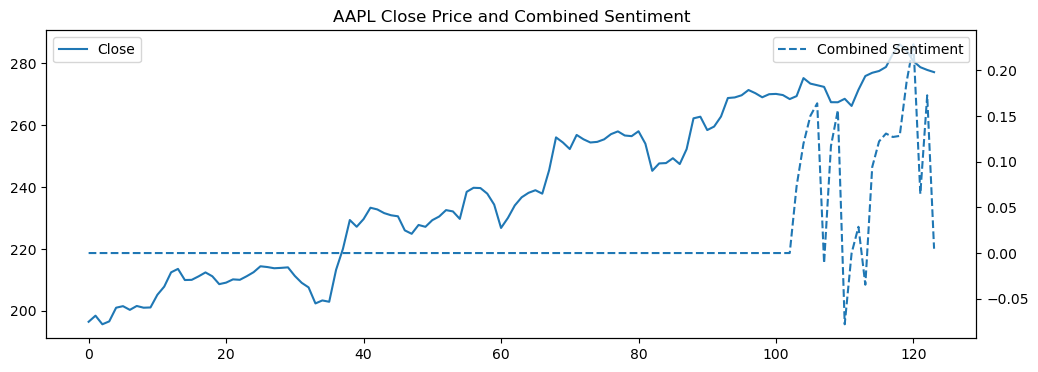

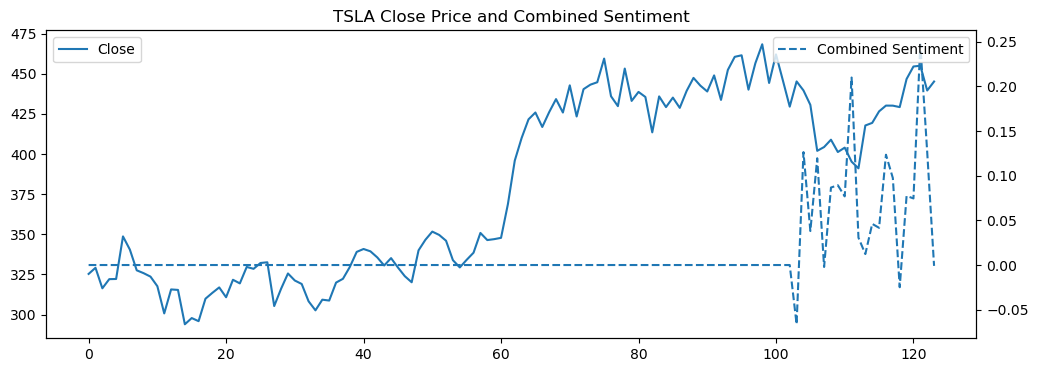

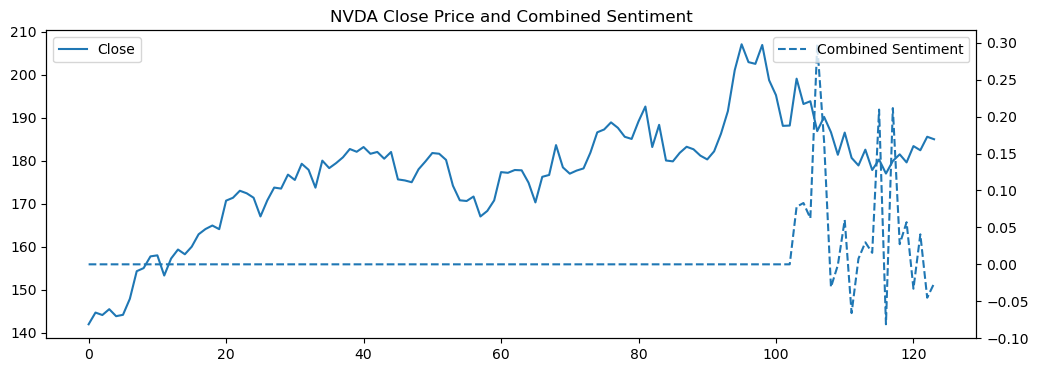

In [60]:
# %% Cell 20 - Plot price and combined sentiment for each ticker (visual)
for t, df in features.items():
    plt.figure(figsize=(12,4))
    df['Close'].plot(label='Close', title=f"{t} Close Price and Combined Sentiment")
    ax = plt.gca()
    ax2 = ax.twinx()
    df['combined_sentiment'].plot(ax=ax2, linestyle='--', label='Combined Sentiment')
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.show()
